In [1]:
!pip install -q accelerate
!pip install -q peft

!pip install -q transformers
!pip install -q autoawq
!pip install -q bitsandbytes
!pip install -q trl

!pip install -q langchain
!pip install -q langchain_community
!pip install -q langchain_openai

!pip install -q sentence_transformers

!pip install -q chromadb
!pip install -q faiss-cpu
!pip install -q langchainhub
!pip install -q rank_bm25

!pip install -q pdfplumber

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/HansolDeco_S3_AI_Construction_Safety')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import gc
import numpy as np

from langchain.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma, FAISS
from langchain_core.runnables import RunnableMap, RunnableLambda, RunnableSequence, RunnablePassthrough

from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA
from langchain.llms import HuggingFacePipeline

from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import bitsandbytes as bnb
import torch

from torch.utils.data import Dataset, DataLoader, ConcatDataset


from sklearn.model_selection import train_test_split
import random
from rank_bm25 import BM25Okapi

from sentence_transformers import SentenceTransformer

import umap
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
from Utils.data_preprocessing import data_preprocessing, pdf_to_text
from Utils.Retriever import retriever, retriever_runnable, ready_retriever
from Utils.prompts import retriever_prompt, non_retriever_prompt
from Evaluate.Matrix import cosine_similarity_sbert, jaccard_similarity, final_score, compute_score
from Training.Train import Training, Evaluating
from Training.dataset_utils import stratified_2d_sampling, PDFDataset, SampleDataset

In [5]:
embedding_model_name = "jhgan/ko-sbert-sts"
embedding_model = SentenceTransformer(embedding_model_name)
model_id = 'hometax/sapie-gemma2-9B-IT'
#model_id = './Models/sapie-gemma2-9B-IT-8bit'
model = AutoModelForCausalLM.from_pretrained(model_id, load_in_8bit=True,trust_remote_code=True, device_map={"": 0})
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
/usr/local/lib/python3.11/dist-packages/transformers/quantizers/auto.py:186: UserWarning: You passed `quantization_config` o

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
pdf_df = pdf_to_text(pdf_directory='./Data/건설안전지침', output_file="./Data/all_construction_guide.csv")
pdf_df.dropna(inplace=True)
pdf_df.reset_index(drop=True, inplace=True)
pdf_df["text_len"] = pdf_df["text"].apply(lambda x: len(tokenizer.tokenize(x)))

'./Data/all_construction_guide.csv' 파일이 이미 존재하여, 이를 불러옵니다.


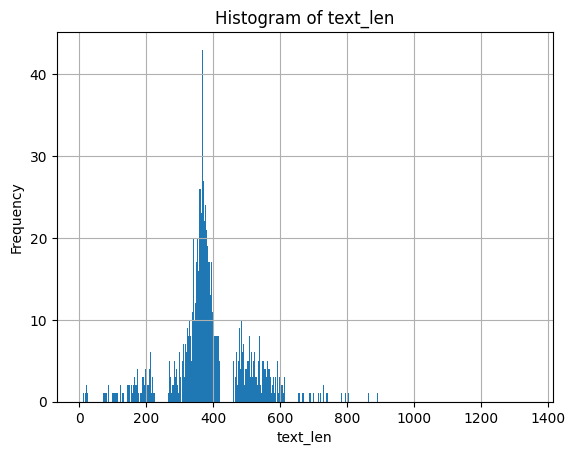

In [ ]:
pdf_df['text_len'].hist(bins=range(min(pdf_df['text_len']), max(pdf_df['text_len']) + 2), align='left', rwidth=0.8)
plt.xlabel('text_len')
plt.ylabel('Frequency')
plt.title('Histogram of text_len')
plt.show()

In [7]:
pdf_df = pdf_df.drop(pdf_df[pdf_df['text_len'] <= 124].index).reset_index(drop=True)
pdf_df = pdf_df.drop(pdf_df[pdf_df['text_len'] >= 1024].index).reset_index(drop=True)

In [8]:
train = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
combined_training_data, combined_test_data = data_preprocessing(train, test)
validation_data = combined_training_data.sample(n=200, random_state=42)
train_data = combined_training_data.drop(validation_data.index).reset_index(drop=True)
validation_data = validation_data.reset_index(drop=True)

In [9]:
train_embeddings = embedding_model.encode(train_data.loc[:, 'answer'])
umap_model = umap.UMAP(n_components=2, random_state=42)
train_embedding_umap = umap_model.fit_transform(train_embeddings)
train_data = pd.concat([train_data, pd.DataFrame(train_embedding_umap, columns=['x', 'y'])], axis=1)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [10]:
total_test_results = {}
total_final_scores = {}
epochs = 3
learning_rate = 5e-5
# 예시: bitsandbytes의 AdamW 8bit 옵티마이저
optimizer = bnb.optim.AdamW8bit(model.parameters(), lr=learning_rate)


In [ ]:
final_score, test_results = Evaluating(model, embedding_model, tokenizer, validation_data, device)
total_test_results[f'Epoch0'] = test_results
total_final_scores[f'Epoch0'] = final_score

Validation:   0%|          | 0/200 [00:00<?, ?it/s]

The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


In [ ]:
print(f"Final Score: {final_score['Final Score']}, Cosine Score: {final_score['Cosine Score']}, Jaccard Score: {final_score['Jaccard Score']}")

Final Score: 0.3312503695487976, Cosine Score: 0.45534709095954895, Jaccard Score: 0.04169189682892218


In [ ]:
for epoch in tqdm(range(epochs), desc="Epoch"):
    pdf_dataset = PDFDataset(pdf_df, tokenizer)
    df_2d_sampled = stratified_2d_sampling(train_data, random_state=(42 + epoch))
    sample_dataset = SampleDataset(df_2d_sampled, tokenizer)
    combined_dataset = ConcatDataset([pdf_dataset, sample_dataset])

    DAPT_loader = DataLoader(combined_dataset, batch_size=1, shuffle=True)


    print(f"Epoch {epoch + 1}/{epochs}")
    train_loss = Training(model, DAPT_loader, tokenizer, optimizer, device=device)
    print(f"Train Loss: {train_loss}")
    final_score, test_results = Evaluating(model, embedding_model, tokenizer, validation_data, device)
    total_test_results[f'Epoch{epoch+1}'] = test_results
    total_final_scores[f'Epoch{epoch+1}'] = final_score
    print(f"Final Score: {final_score['Final Score']}, Cosine Score: {final_score['Cosine Score']}, Jaccard Score: {final_score['Jaccard Score']}")

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3


Training:   0%|          | 0/3740 [00:00<?, ?it/s]

Global Step 100, Avg Train Loss: 2.270979
Global Step 200, Avg Train Loss: 2.187119
Global Step 300, Avg Train Loss: 2.100084
Global Step 400, Avg Train Loss: 2.059099
Global Step 500, Avg Train Loss: 2.027186
Global Step 600, Avg Train Loss: 1.997062
Global Step 700, Avg Train Loss: 1.971779
Global Step 800, Avg Train Loss: 1.949237
Global Step 900, Avg Train Loss: 1.940567
Global Step 1000, Avg Train Loss: 1.914522
Global Step 1100, Avg Train Loss: 1.896235
Global Step 1200, Avg Train Loss: 1.871504
Global Step 1300, Avg Train Loss: 1.862791
Global Step 1400, Avg Train Loss: 1.845479
Global Step 1500, Avg Train Loss: 1.831759
Global Step 1600, Avg Train Loss: 1.819639
Global Step 1700, Avg Train Loss: 1.814220
Global Step 1800, Avg Train Loss: 1.799842
Global Step 1900, Avg Train Loss: 1.795980
Global Step 2000, Avg Train Loss: 1.784136
Global Step 2100, Avg Train Loss: 1.778392
Global Step 2200, Avg Train Loss: 1.766050
Global Step 2300, Avg Train Loss: 1.756143
Global Step 2400, Av

Validation:   0%|          | 0/200 [00:00<?, ?it/s]

Final Score: 0.39261773228645325, Cosine Score: 0.5339885950088501, Jaccard Score: 0.06275233238069026
Epoch 2/3


Training:   0%|          | 0/3740 [00:00<?, ?it/s]

Global Step 100, Avg Train Loss: 1.422641
Global Step 200, Avg Train Loss: 1.413414
Global Step 300, Avg Train Loss: 1.442794
Global Step 400, Avg Train Loss: 1.446909
Global Step 500, Avg Train Loss: 1.418763
Global Step 600, Avg Train Loss: 1.430385
Global Step 700, Avg Train Loss: 1.436664
Global Step 800, Avg Train Loss: 1.437645
Global Step 900, Avg Train Loss: 1.444824
Global Step 1000, Avg Train Loss: 1.450326
Global Step 1100, Avg Train Loss: 1.448332
Global Step 1200, Avg Train Loss: 1.450734
Global Step 1300, Avg Train Loss: 1.452147
Global Step 1400, Avg Train Loss: 1.450934
Global Step 1500, Avg Train Loss: 1.443220
Global Step 1600, Avg Train Loss: 1.441922
Global Step 1700, Avg Train Loss: 1.445045
Global Step 1800, Avg Train Loss: 1.446572
Global Step 1900, Avg Train Loss: 1.452203
Global Step 2000, Avg Train Loss: 1.454543
Global Step 2100, Avg Train Loss: 1.455750
Global Step 2200, Avg Train Loss: 1.452552
Global Step 2300, Avg Train Loss: 1.449161
Global Step 2400, Av

Validation:   0%|          | 0/200 [00:00<?, ?it/s]

Final Score: 0.394039124250412, Cosine Score: 0.5357134938240051, Jaccard Score: 0.063465345034369
Epoch 3/3


Training:   0%|          | 0/3740 [00:00<?, ?it/s]

Global Step 100, Avg Train Loss: 1.199431
Global Step 200, Avg Train Loss: 1.309658
Global Step 300, Avg Train Loss: 1.308158
Global Step 400, Avg Train Loss: 1.318408
Global Step 500, Avg Train Loss: 1.317821
Global Step 600, Avg Train Loss: 1.319998
Global Step 700, Avg Train Loss: 1.323862
Global Step 800, Avg Train Loss: 1.311876
Global Step 900, Avg Train Loss: 1.310414
Global Step 1000, Avg Train Loss: 1.319759
Global Step 1100, Avg Train Loss: 1.313541
Global Step 1200, Avg Train Loss: 1.317270
Global Step 1300, Avg Train Loss: 1.326147
Global Step 1400, Avg Train Loss: 1.328552
Global Step 1500, Avg Train Loss: 1.328057
Global Step 1600, Avg Train Loss: 1.327024
Global Step 1700, Avg Train Loss: 1.326568
Global Step 1800, Avg Train Loss: 1.329600
Global Step 1900, Avg Train Loss: 1.328879
Global Step 2000, Avg Train Loss: 1.328002
Global Step 2100, Avg Train Loss: 1.327748
Global Step 2200, Avg Train Loss: 1.327523
Global Step 2300, Avg Train Loss: 1.325704
Global Step 2400, Av

Validation:   0%|          | 0/200 [00:00<?, ?it/s]

Final Score: 0.4011543393135071, Cosine Score: 0.5487964153289795, Jaccard Score: 0.056655629872637815


In [ ]:
print("Causal LM DAPT 완성!")
model.save_pretrained("./Models/DAPT_Model(gemma2)", safe_serialization=True)
tokenizer.save_pretrained("./Models/DAPT_Model(gemma2)", safe_serialization=True)

Causal LM DAPT 완성!


('./Models/DAPT_Model(lg_exaone)/tokenizer_config.json',
 './Models/DAPT_Model(lg_exaone)/special_tokens_map.json',
 './Models/DAPT_Model(lg_exaone)/vocab.json',
 './Models/DAPT_Model(lg_exaone)/merges.txt',
 './Models/DAPT_Model(lg_exaone)/added_tokens.json',
 './Models/DAPT_Model(lg_exaone)/tokenizer.json')